### 2a. 
Build a Convolutional Neural Network, like what we built in lectures (without skip connections), to classify the images across all 10 classes in CIFAR 10. You need to adjust the fully connected layer at the end properly with respect to the number of output classes. Train your network for 300 epochs. Report your training time, training loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare them against a fully connected network (homework 2) on training time, achieved accuracy, and model size.

#### CIFAR 10 setup:

In [24]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda:0')
print(torch.cuda.is_available())

True


In [25]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


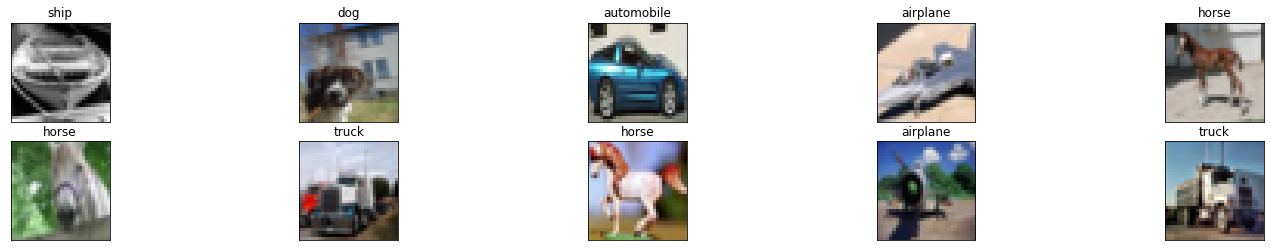

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 10 images
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#### Model 1 Architecture:

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# create a complete CNN
model1 = Net1()
if torch.cuda.is_available():
    model1.cuda()
print(model1)


Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [28]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model1.parameters(), lr=.01)

#### Model 1: training & testing

In [29]:
%%time
from tqdm import tqdm

# number of epochs to train the model
n_epochs = 300

#List to store loss to visualize
train_losslist = []

# track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  print('\nEpoch: {}'.format(epoch))
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  print('training: ')  
  with tqdm(train_loader, unit="batch") as tepoch:  
    # train the model
    model1.train()
    for data, target in tepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
  print('validation: ')      
  with tqdm(valid_loader, unit="batch") as vepoch:
    # validate the model
    model1.eval()
    for data, target in vepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_losslist.append(train_loss)
        
  # print training/validation statistics 
  print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model1.state_dict(), 'model1_cifar.pt')
      valid_loss_min = valid_loss

# plt.plot(n_epochs, train_losslist)
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Performance of Model 1")
# plt.show()


Epoch: 1
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.27batch/s]


Training Loss: 1.757462 	Validation Loss: 0.389919
Validation loss decreased (inf --> 0.389919).  Saving model ...

Epoch: 2
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.08batch/s]


Training Loss: 1.421384 	Validation Loss: 0.321831
Validation loss decreased (0.389919 --> 0.321831).  Saving model ...

Epoch: 3
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.26batch/s]


Training Loss: 1.234788 	Validation Loss: 0.288718
Validation loss decreased (0.321831 --> 0.288718).  Saving model ...

Epoch: 4
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.61batch/s]


Training Loss: 1.134695 	Validation Loss: 0.270984
Validation loss decreased (0.288718 --> 0.270984).  Saving model ...

Epoch: 5
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.99batch/s]


Training Loss: 1.058859 	Validation Loss: 0.255602
Validation loss decreased (0.270984 --> 0.255602).  Saving model ...

Epoch: 6
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.67batch/s]


Training Loss: 0.993789 	Validation Loss: 0.243864
Validation loss decreased (0.255602 --> 0.243864).  Saving model ...

Epoch: 7
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.69batch/s]


Training Loss: 0.941940 	Validation Loss: 0.231812
Validation loss decreased (0.243864 --> 0.231812).  Saving model ...

Epoch: 8
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.79batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.91batch/s]


Training Loss: 0.892383 	Validation Loss: 0.225812
Validation loss decreased (0.231812 --> 0.225812).  Saving model ...

Epoch: 9
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.20batch/s]


Training Loss: 0.855296 	Validation Loss: 0.220332
Validation loss decreased (0.225812 --> 0.220332).  Saving model ...

Epoch: 10
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.63batch/s]


Training Loss: 0.819061 	Validation Loss: 0.227175

Epoch: 11
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.90batch/s]


Training Loss: 0.788577 	Validation Loss: 0.217631
Validation loss decreased (0.220332 --> 0.217631).  Saving model ...

Epoch: 12
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.14batch/s]


Training Loss: 0.754990 	Validation Loss: 0.210261
Validation loss decreased (0.217631 --> 0.210261).  Saving model ...

Epoch: 13
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.03batch/s]


Training Loss: 0.731070 	Validation Loss: 0.208650
Validation loss decreased (0.210261 --> 0.208650).  Saving model ...

Epoch: 14
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.95batch/s]


Training Loss: 0.704254 	Validation Loss: 0.205846
Validation loss decreased (0.208650 --> 0.205846).  Saving model ...

Epoch: 15
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.73batch/s]


Training Loss: 0.677104 	Validation Loss: 0.214854

Epoch: 16
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.15batch/s]


Training Loss: 0.657665 	Validation Loss: 0.205782
Validation loss decreased (0.205846 --> 0.205782).  Saving model ...

Epoch: 17
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.66batch/s]


Training Loss: 0.632763 	Validation Loss: 0.207484

Epoch: 18
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.38batch/s]


Training Loss: 0.612742 	Validation Loss: 0.205958

Epoch: 19
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.70batch/s]


Training Loss: 0.592407 	Validation Loss: 0.206495

Epoch: 20
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.65batch/s]


Training Loss: 0.569058 	Validation Loss: 0.215376

Epoch: 21
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.25batch/s]


Training Loss: 0.553143 	Validation Loss: 0.220697

Epoch: 22
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.62batch/s]


Training Loss: 0.531384 	Validation Loss: 0.215885

Epoch: 23
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.50batch/s]


Training Loss: 0.515285 	Validation Loss: 0.223674

Epoch: 24
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.15batch/s]


Training Loss: 0.497355 	Validation Loss: 0.223637

Epoch: 25
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.71batch/s]


Training Loss: 0.477719 	Validation Loss: 0.223932

Epoch: 26
training: 


100%|██████████| 2000/2000 [00:13<00:00, 151.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.79batch/s]


Training Loss: 0.463641 	Validation Loss: 0.239740

Epoch: 27
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.73batch/s]


Training Loss: 0.442906 	Validation Loss: 0.242614

Epoch: 28
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.39batch/s]


Training Loss: 0.430033 	Validation Loss: 0.250085

Epoch: 29
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 195.98batch/s]


Training Loss: 0.413878 	Validation Loss: 0.240355

Epoch: 30
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.17batch/s]


Training Loss: 0.399666 	Validation Loss: 0.257965

Epoch: 31
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.46batch/s]


Training Loss: 0.383628 	Validation Loss: 0.267584

Epoch: 32
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.73batch/s]


Training Loss: 0.371313 	Validation Loss: 0.278706

Epoch: 33
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.79batch/s]


Training Loss: 0.353464 	Validation Loss: 0.285868

Epoch: 34
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.88batch/s]


Training Loss: 0.342384 	Validation Loss: 0.286694

Epoch: 35
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.95batch/s]


Training Loss: 0.335657 	Validation Loss: 0.298471

Epoch: 36
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.42batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.92batch/s]


Training Loss: 0.317048 	Validation Loss: 0.303376

Epoch: 37
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.38batch/s]


Training Loss: 0.308168 	Validation Loss: 0.303494

Epoch: 38
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.35batch/s]


Training Loss: 0.296698 	Validation Loss: 0.308911

Epoch: 39
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.38batch/s]


Training Loss: 0.293135 	Validation Loss: 0.332471

Epoch: 40
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.23batch/s]


Training Loss: 0.276745 	Validation Loss: 0.320262

Epoch: 41
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.36batch/s]


Training Loss: 0.268932 	Validation Loss: 0.340628

Epoch: 42
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.14batch/s]


Training Loss: 0.261651 	Validation Loss: 0.339879

Epoch: 43
training: 


100%|██████████| 2000/2000 [00:11<00:00, 174.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.42batch/s]


Training Loss: 0.245074 	Validation Loss: 0.364613

Epoch: 44
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.00batch/s]


Training Loss: 0.247526 	Validation Loss: 0.359830

Epoch: 45
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.93batch/s]


Training Loss: 0.237821 	Validation Loss: 0.356249

Epoch: 46
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.55batch/s]


Training Loss: 0.225623 	Validation Loss: 0.391796

Epoch: 47
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.42batch/s]


Training Loss: 0.225818 	Validation Loss: 0.383228

Epoch: 48
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.72batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.17batch/s]


Training Loss: 0.212996 	Validation Loss: 0.402085

Epoch: 49
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.92batch/s]


Training Loss: 0.213256 	Validation Loss: 0.411619

Epoch: 50
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.81batch/s]


Training Loss: 0.207126 	Validation Loss: 0.439412

Epoch: 51
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.86batch/s]


Training Loss: 0.202335 	Validation Loss: 0.426025

Epoch: 52
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.29batch/s]


Training Loss: 0.192346 	Validation Loss: 0.443285

Epoch: 53
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.05batch/s]


Training Loss: 0.188336 	Validation Loss: 0.439912

Epoch: 54
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.46batch/s]


Training Loss: 0.189497 	Validation Loss: 0.449672

Epoch: 55
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.39batch/s]


Training Loss: 0.180383 	Validation Loss: 0.465165

Epoch: 56
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.81batch/s]


Training Loss: 0.175190 	Validation Loss: 0.482206

Epoch: 57
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.58batch/s]


Training Loss: 0.159263 	Validation Loss: 0.489261

Epoch: 58
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.19batch/s]


Training Loss: 0.177768 	Validation Loss: 0.499535

Epoch: 59
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.85batch/s]


Training Loss: 0.162015 	Validation Loss: 0.506233

Epoch: 60
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.49batch/s]


Training Loss: 0.159926 	Validation Loss: 0.503218

Epoch: 61
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.88batch/s]


Training Loss: 0.160087 	Validation Loss: 0.517392

Epoch: 62
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.86batch/s]


Training Loss: 0.156343 	Validation Loss: 0.533574

Epoch: 63
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.30batch/s]


Training Loss: 0.153412 	Validation Loss: 0.557181

Epoch: 64
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.21batch/s]


Training Loss: 0.155748 	Validation Loss: 0.580788

Epoch: 65
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.10batch/s]


Training Loss: 0.153730 	Validation Loss: 0.614477

Epoch: 66
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.65batch/s]


Training Loss: 0.142394 	Validation Loss: 0.557287

Epoch: 67
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.02batch/s]


Training Loss: 0.136485 	Validation Loss: 0.570954

Epoch: 68
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.22batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.23batch/s]


Training Loss: 0.148038 	Validation Loss: 0.582366

Epoch: 69
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.42batch/s]


Training Loss: 0.140141 	Validation Loss: 0.586354

Epoch: 70
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.96batch/s]


Training Loss: 0.143387 	Validation Loss: 0.586362

Epoch: 71
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.57batch/s]


Training Loss: 0.130181 	Validation Loss: 0.597345

Epoch: 72
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.11batch/s]


Training Loss: 0.137129 	Validation Loss: 0.621641

Epoch: 73
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.88batch/s]


Training Loss: 0.132960 	Validation Loss: 0.603785

Epoch: 74
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.36batch/s]


Training Loss: 0.117963 	Validation Loss: 0.627930

Epoch: 75
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.90batch/s]


Training Loss: 0.117050 	Validation Loss: 0.623404

Epoch: 76
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.03batch/s]


Training Loss: 0.122383 	Validation Loss: 0.633451

Epoch: 77
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.51batch/s]


Training Loss: 0.135328 	Validation Loss: 0.651493

Epoch: 78
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.51batch/s]


Training Loss: 0.117817 	Validation Loss: 0.664856

Epoch: 79
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.77batch/s]


Training Loss: 0.121680 	Validation Loss: 0.682717

Epoch: 80
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.71batch/s]


Training Loss: 0.114218 	Validation Loss: 0.653445

Epoch: 81
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.55batch/s]


Training Loss: 0.113947 	Validation Loss: 0.678821

Epoch: 82
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.94batch/s]


Training Loss: 0.109419 	Validation Loss: 0.672969

Epoch: 83
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.92batch/s]


Training Loss: 0.130623 	Validation Loss: 0.683762

Epoch: 84
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.82batch/s]


Training Loss: 0.101415 	Validation Loss: 0.703617

Epoch: 85
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.24batch/s]


Training Loss: 0.095865 	Validation Loss: 0.704584

Epoch: 86
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.14batch/s]


Training Loss: 0.122871 	Validation Loss: 0.692150

Epoch: 87
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.09batch/s]


Training Loss: 0.099175 	Validation Loss: 0.747902

Epoch: 88
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.97batch/s]


Training Loss: 0.095629 	Validation Loss: 0.730957

Epoch: 89
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.04batch/s]


Training Loss: 0.096444 	Validation Loss: 0.790907

Epoch: 90
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.24batch/s]


Training Loss: 0.105905 	Validation Loss: 0.741074

Epoch: 91
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.15batch/s]


Training Loss: 0.117928 	Validation Loss: 0.729267

Epoch: 92
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.00batch/s]


Training Loss: 0.113048 	Validation Loss: 0.733716

Epoch: 93
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.05batch/s]


Training Loss: 0.099551 	Validation Loss: 0.763012

Epoch: 94
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.29batch/s]


Training Loss: 0.097251 	Validation Loss: 0.738877

Epoch: 95
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.50batch/s]


Training Loss: 0.090460 	Validation Loss: 0.767021

Epoch: 96
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.98batch/s]


Training Loss: 0.107798 	Validation Loss: 0.759739

Epoch: 97
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.07batch/s]


Training Loss: 0.094819 	Validation Loss: 0.782413

Epoch: 98
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.20batch/s]


Training Loss: 0.104088 	Validation Loss: 0.770228

Epoch: 99
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.73batch/s]


Training Loss: 0.109697 	Validation Loss: 0.773450

Epoch: 100
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.90batch/s]


Training Loss: 0.105882 	Validation Loss: 0.828790

Epoch: 101
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.11batch/s]


Training Loss: 0.090049 	Validation Loss: 0.806668

Epoch: 102
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.70batch/s]


Training Loss: 0.097359 	Validation Loss: 0.789066

Epoch: 103
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.13batch/s]


Training Loss: 0.100091 	Validation Loss: 0.818728

Epoch: 104
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.10batch/s]


Training Loss: 0.082365 	Validation Loss: 0.831831

Epoch: 105
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.55batch/s]


Training Loss: 0.090090 	Validation Loss: 0.821635

Epoch: 106
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.85batch/s]


Training Loss: 0.099939 	Validation Loss: 0.832247

Epoch: 107
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 236.34batch/s]


Training Loss: 0.104108 	Validation Loss: 0.863762

Epoch: 108
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.46batch/s]


Training Loss: 0.083501 	Validation Loss: 0.816108

Epoch: 109
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.86batch/s]


Training Loss: 0.073838 	Validation Loss: 0.822306

Epoch: 110
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.80batch/s]


Training Loss: 0.070925 	Validation Loss: 0.860062

Epoch: 111
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.42batch/s]


Training Loss: 0.111783 	Validation Loss: 0.833352

Epoch: 112
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.09batch/s]


Training Loss: 0.099434 	Validation Loss: 0.852122

Epoch: 113
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.58batch/s]


Training Loss: 0.109155 	Validation Loss: 0.852605

Epoch: 114
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.32batch/s]


Training Loss: 0.095376 	Validation Loss: 0.889777

Epoch: 115
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.63batch/s]


Training Loss: 0.090740 	Validation Loss: 0.899021

Epoch: 116
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.97batch/s]


Training Loss: 0.088293 	Validation Loss: 0.883710

Epoch: 117
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.00batch/s]


Training Loss: 0.069269 	Validation Loss: 0.880954

Epoch: 118
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.99batch/s]


Training Loss: 0.088990 	Validation Loss: 0.854879

Epoch: 119
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.48batch/s]


Training Loss: 0.092052 	Validation Loss: 0.855430

Epoch: 120
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.18batch/s]


Training Loss: 0.084798 	Validation Loss: 0.891954

Epoch: 121
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.89batch/s]


Training Loss: 0.101085 	Validation Loss: 0.843403

Epoch: 122
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.37batch/s]


Training Loss: 0.068699 	Validation Loss: 0.980310

Epoch: 123
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.70batch/s]


Training Loss: 0.100333 	Validation Loss: 0.901905

Epoch: 124
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.88batch/s]


Training Loss: 0.073660 	Validation Loss: 0.930032

Epoch: 125
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.48batch/s]


Training Loss: 0.075488 	Validation Loss: 0.967987

Epoch: 126
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.31batch/s]


Training Loss: 0.087094 	Validation Loss: 0.895765

Epoch: 127
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.47batch/s]


Training Loss: 0.075257 	Validation Loss: 0.937521

Epoch: 128
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.66batch/s]


Training Loss: 0.083670 	Validation Loss: 0.969139

Epoch: 129
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.58batch/s]


Training Loss: 0.071838 	Validation Loss: 0.942414

Epoch: 130
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.97batch/s]


Training Loss: 0.108754 	Validation Loss: 0.896264

Epoch: 131
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.97batch/s]


Training Loss: 0.096230 	Validation Loss: 0.945217

Epoch: 132
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.85batch/s]


Training Loss: 0.086770 	Validation Loss: 0.903683

Epoch: 133
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.98batch/s]


Training Loss: 0.085956 	Validation Loss: 0.919079

Epoch: 134
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.44batch/s]


Training Loss: 0.088392 	Validation Loss: 0.932273

Epoch: 135
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.22batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.40batch/s]


Training Loss: 0.072675 	Validation Loss: 0.939792

Epoch: 136
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.79batch/s]


Training Loss: 0.096992 	Validation Loss: 0.931964

Epoch: 137
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.82batch/s]


Training Loss: 0.072959 	Validation Loss: 0.927965

Epoch: 138
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.40batch/s]


Training Loss: 0.050137 	Validation Loss: 0.977467

Epoch: 139
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.40batch/s]


Training Loss: 0.054679 	Validation Loss: 0.992839

Epoch: 140
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.14batch/s]


Training Loss: 0.064425 	Validation Loss: 1.018782

Epoch: 141
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.78batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.45batch/s]


Training Loss: 0.090773 	Validation Loss: 0.973726

Epoch: 142
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.00batch/s]


Training Loss: 0.112610 	Validation Loss: 0.971749

Epoch: 143
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.54batch/s]


Training Loss: 0.087082 	Validation Loss: 0.944218

Epoch: 144
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.49batch/s]


Training Loss: 0.094149 	Validation Loss: 0.947276

Epoch: 145
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.41batch/s]


Training Loss: 0.070490 	Validation Loss: 0.961364

Epoch: 146
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.37batch/s]


Training Loss: 0.061481 	Validation Loss: 0.978990

Epoch: 147
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.91batch/s]


Training Loss: 0.081307 	Validation Loss: 1.012684

Epoch: 148
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.87batch/s]


Training Loss: 0.098011 	Validation Loss: 1.053656

Epoch: 149
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.03batch/s]


Training Loss: 0.081268 	Validation Loss: 1.044266

Epoch: 150
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.53batch/s]


Training Loss: 0.073730 	Validation Loss: 1.024182

Epoch: 151
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.64batch/s]


Training Loss: 0.074611 	Validation Loss: 1.026943

Epoch: 152
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.70batch/s]


Training Loss: 0.090964 	Validation Loss: 0.994701

Epoch: 153
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.93batch/s]


Training Loss: 0.093771 	Validation Loss: 1.004853

Epoch: 154
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.09batch/s]


Training Loss: 0.091390 	Validation Loss: 1.026204

Epoch: 155
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.89batch/s]


Training Loss: 0.078519 	Validation Loss: 1.038680

Epoch: 156
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.05batch/s]


Training Loss: 0.104766 	Validation Loss: 1.027823

Epoch: 157
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.25batch/s]


Training Loss: 0.071606 	Validation Loss: 1.000326

Epoch: 158
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.01batch/s]


Training Loss: 0.099217 	Validation Loss: 1.010333

Epoch: 159
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.75batch/s]


Training Loss: 0.085728 	Validation Loss: 0.991522

Epoch: 160
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.99batch/s]


Training Loss: 0.062612 	Validation Loss: 1.056954

Epoch: 161
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.20batch/s]


Training Loss: 0.052672 	Validation Loss: 1.099473

Epoch: 162
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.77batch/s]


Training Loss: 0.062449 	Validation Loss: 1.059731

Epoch: 163
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.77batch/s]


Training Loss: 0.077929 	Validation Loss: 1.062851

Epoch: 164
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.72batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.27batch/s]


Training Loss: 0.097275 	Validation Loss: 1.024983

Epoch: 165
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.14batch/s]


Training Loss: 0.103309 	Validation Loss: 1.055819

Epoch: 166
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.61batch/s]


Training Loss: 0.093610 	Validation Loss: 1.079795

Epoch: 167
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.14batch/s]


Training Loss: 0.078834 	Validation Loss: 1.077539

Epoch: 168
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.09batch/s]


Training Loss: 0.087711 	Validation Loss: 1.082410

Epoch: 169
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 194.58batch/s]


Training Loss: 0.073372 	Validation Loss: 1.085942

Epoch: 170
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 198.33batch/s]


Training Loss: 0.086071 	Validation Loss: 1.070168

Epoch: 171
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.17batch/s]


Training Loss: 0.093200 	Validation Loss: 1.081586

Epoch: 172
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.20batch/s]


Training Loss: 0.086026 	Validation Loss: 1.119607

Epoch: 173
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.03batch/s]


Training Loss: 0.111790 	Validation Loss: 1.044226

Epoch: 174
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.30batch/s]


Training Loss: 0.076377 	Validation Loss: 1.068867

Epoch: 175
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 200.65batch/s]


Training Loss: 0.078752 	Validation Loss: 1.099828

Epoch: 176
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.57batch/s]


Training Loss: 0.064435 	Validation Loss: 1.068443

Epoch: 177
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.99batch/s]


Training Loss: 0.069439 	Validation Loss: 1.093201

Epoch: 178
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 193.53batch/s]


Training Loss: 0.063519 	Validation Loss: 1.123962

Epoch: 179
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.58batch/s]


Training Loss: 0.069538 	Validation Loss: 1.122219

Epoch: 180
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.89batch/s]


Training Loss: 0.068572 	Validation Loss: 1.174746

Epoch: 181
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 198.69batch/s]


Training Loss: 0.099542 	Validation Loss: 1.192727

Epoch: 182
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.02batch/s]


Training Loss: 0.114146 	Validation Loss: 1.114896

Epoch: 183
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.44batch/s]


Training Loss: 0.104244 	Validation Loss: 1.075864

Epoch: 184
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.08batch/s]


Training Loss: 0.074181 	Validation Loss: 1.118494

Epoch: 185
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.81batch/s]


Training Loss: 0.109798 	Validation Loss: 1.067513

Epoch: 186
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.65batch/s]


Training Loss: 0.089689 	Validation Loss: 1.111821

Epoch: 187
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.43batch/s]


Training Loss: 0.080121 	Validation Loss: 1.132177

Epoch: 188
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.38batch/s]


Training Loss: 0.055083 	Validation Loss: 1.187686

Epoch: 189
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.88batch/s]


Training Loss: 0.083867 	Validation Loss: 1.123743

Epoch: 190
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.24batch/s]


Training Loss: 0.070679 	Validation Loss: 1.166898

Epoch: 191
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.07batch/s]


Training Loss: 0.065227 	Validation Loss: 1.198881

Epoch: 192
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.41batch/s]


Training Loss: 0.075607 	Validation Loss: 1.171333

Epoch: 193
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.11batch/s]


Training Loss: 0.103956 	Validation Loss: 1.123739

Epoch: 194
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.39batch/s]


Training Loss: 0.095126 	Validation Loss: 1.136930

Epoch: 195
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.79batch/s]


Training Loss: 0.093396 	Validation Loss: 1.126603

Epoch: 196
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.60batch/s]


Training Loss: 0.104030 	Validation Loss: 1.104877

Epoch: 197
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.29batch/s]


Training Loss: 0.056700 	Validation Loss: 1.202612

Epoch: 198
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.14batch/s]


Training Loss: 0.063295 	Validation Loss: 1.125331

Epoch: 199
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.17batch/s]


Training Loss: 0.078109 	Validation Loss: 1.197027

Epoch: 200
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.01batch/s]


Training Loss: 0.086226 	Validation Loss: 1.195221

Epoch: 201
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.61batch/s]


Training Loss: 0.131739 	Validation Loss: 1.120685

Epoch: 202
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.52batch/s]


Training Loss: 0.080293 	Validation Loss: 1.160154

Epoch: 203
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.04batch/s]


Training Loss: 0.075949 	Validation Loss: 1.181358

Epoch: 204
training: 


100%|██████████| 2000/2000 [00:11<00:00, 174.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.58batch/s]


Training Loss: 0.063527 	Validation Loss: 1.213302

Epoch: 205
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.41batch/s]


Training Loss: 0.073025 	Validation Loss: 1.223317

Epoch: 206
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.08batch/s]


Training Loss: 0.095449 	Validation Loss: 1.221234

Epoch: 207
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.79batch/s]


Training Loss: 0.073753 	Validation Loss: 1.244611

Epoch: 208
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.50batch/s]


Training Loss: 0.091835 	Validation Loss: 1.229588

Epoch: 209
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.90batch/s]


Training Loss: 0.121044 	Validation Loss: 1.227081

Epoch: 210
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.59batch/s]


Training Loss: 0.130136 	Validation Loss: 1.231006

Epoch: 211
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.74batch/s]


Training Loss: 0.113988 	Validation Loss: 1.169029

Epoch: 212
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.17batch/s]


Training Loss: 0.083720 	Validation Loss: 1.193644

Epoch: 213
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.46batch/s]


Training Loss: 0.074147 	Validation Loss: 1.181144

Epoch: 214
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.30batch/s]


Training Loss: 0.071117 	Validation Loss: 1.204490

Epoch: 215
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.16batch/s]


Training Loss: 0.092184 	Validation Loss: 1.213928

Epoch: 216
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.80batch/s]


Training Loss: 0.085727 	Validation Loss: 1.221710

Epoch: 217
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.56batch/s]


Training Loss: 0.067167 	Validation Loss: 1.194933

Epoch: 218
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.83batch/s]


Training Loss: 0.104449 	Validation Loss: 1.253930

Epoch: 219
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.78batch/s]


Training Loss: 0.099386 	Validation Loss: 1.216856

Epoch: 220
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.48batch/s]


Training Loss: 0.097698 	Validation Loss: 1.216798

Epoch: 221
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.20batch/s]


Training Loss: 0.086732 	Validation Loss: 1.227137

Epoch: 222
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.96batch/s]


Training Loss: 0.100997 	Validation Loss: 1.206560

Epoch: 223
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.36batch/s]


Training Loss: 0.092139 	Validation Loss: 1.243462

Epoch: 224
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.48batch/s]


Training Loss: 0.060475 	Validation Loss: 1.259059

Epoch: 225
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.10batch/s]


Training Loss: 0.092710 	Validation Loss: 1.249722

Epoch: 226
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.66batch/s]


Training Loss: 0.089473 	Validation Loss: 1.225320

Epoch: 227
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.17batch/s]


Training Loss: 0.101988 	Validation Loss: 1.308505

Epoch: 228
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.58batch/s]


Training Loss: 0.091921 	Validation Loss: 1.263501

Epoch: 229
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.38batch/s]


Training Loss: 0.078876 	Validation Loss: 1.271766

Epoch: 230
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.48batch/s]


Training Loss: 0.089187 	Validation Loss: 1.304586

Epoch: 231
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.17batch/s]


Training Loss: 0.104683 	Validation Loss: 1.214249

Epoch: 232
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.68batch/s]


Training Loss: 0.069261 	Validation Loss: 1.285973

Epoch: 233
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.07batch/s]


Training Loss: 0.087793 	Validation Loss: 1.227858

Epoch: 234
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.81batch/s]


Training Loss: 0.085488 	Validation Loss: 1.296410

Epoch: 235
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.56batch/s]


Training Loss: 0.111122 	Validation Loss: 1.238198

Epoch: 236
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.82batch/s]


Training Loss: 0.106237 	Validation Loss: 1.256026

Epoch: 237
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.53batch/s]


Training Loss: 0.101057 	Validation Loss: 1.290118

Epoch: 238
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.14batch/s]


Training Loss: 0.111390 	Validation Loss: 1.298568

Epoch: 239
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.51batch/s]


Training Loss: 0.114823 	Validation Loss: 1.282142

Epoch: 240
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.79batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.07batch/s]


Training Loss: 0.083900 	Validation Loss: 1.263164

Epoch: 241
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.06batch/s]


Training Loss: 0.054688 	Validation Loss: 1.259766

Epoch: 242
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.23batch/s]


Training Loss: 0.044074 	Validation Loss: 1.305021

Epoch: 243
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.44batch/s]


Training Loss: 0.073409 	Validation Loss: 1.319386

Epoch: 244
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.85batch/s]


Training Loss: 0.074701 	Validation Loss: 1.318837

Epoch: 245
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.20batch/s]


Training Loss: 0.120353 	Validation Loss: 1.283552

Epoch: 246
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.78batch/s]


Training Loss: 0.111869 	Validation Loss: 1.336754

Epoch: 247
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.29batch/s]


Training Loss: 0.112842 	Validation Loss: 1.307293

Epoch: 248
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.49batch/s]


Training Loss: 0.085386 	Validation Loss: 1.303710

Epoch: 249
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.76batch/s]


Training Loss: 0.096092 	Validation Loss: 1.311120

Epoch: 250
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.38batch/s]


Training Loss: 0.116986 	Validation Loss: 1.274527

Epoch: 251
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.46batch/s]


Training Loss: 0.076225 	Validation Loss: 1.319196

Epoch: 252
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.83batch/s]


Training Loss: 0.077813 	Validation Loss: 1.298294

Epoch: 253
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.00batch/s]


Training Loss: 0.096304 	Validation Loss: 1.305799

Epoch: 254
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.14batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 146.18batch/s]


Training Loss: 0.103968 	Validation Loss: 1.339295

Epoch: 255
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.98batch/s]


Training Loss: 0.084146 	Validation Loss: 1.364397

Epoch: 256
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.46batch/s]


Training Loss: 0.127519 	Validation Loss: 1.328434

Epoch: 257
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.20batch/s]


Training Loss: 0.105520 	Validation Loss: 1.313787

Epoch: 258
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.29batch/s]


Training Loss: 0.095312 	Validation Loss: 1.413591

Epoch: 259
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.96batch/s]


Training Loss: 0.095476 	Validation Loss: 1.340057

Epoch: 260
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.79batch/s]


Training Loss: 0.100666 	Validation Loss: 1.302966

Epoch: 261
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.31batch/s]


Training Loss: 0.106305 	Validation Loss: 1.297490

Epoch: 262
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.37batch/s]


Training Loss: 0.130771 	Validation Loss: 1.292515

Epoch: 263
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.33batch/s]


Training Loss: 0.112397 	Validation Loss: 1.315505

Epoch: 264
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.87batch/s]


Training Loss: 0.104464 	Validation Loss: 1.308807

Epoch: 265
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.78batch/s]


Training Loss: 0.094052 	Validation Loss: 1.303421

Epoch: 266
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.42batch/s]


Training Loss: 0.105665 	Validation Loss: 1.356337

Epoch: 267
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.51batch/s]


Training Loss: 0.116161 	Validation Loss: 1.388457

Epoch: 268
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.65batch/s]


Training Loss: 0.110120 	Validation Loss: 1.265005

Epoch: 269
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.86batch/s]


Training Loss: 0.068387 	Validation Loss: 1.315391

Epoch: 270
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.87batch/s]


Training Loss: 0.057161 	Validation Loss: 1.356592

Epoch: 271
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.23batch/s]


Training Loss: 0.076430 	Validation Loss: 1.320264

Epoch: 272
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.85batch/s]


Training Loss: 0.076548 	Validation Loss: 1.410659

Epoch: 273
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.65batch/s]


Training Loss: 0.107089 	Validation Loss: 1.371476

Epoch: 274
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.73batch/s]


Training Loss: 0.111723 	Validation Loss: 1.386919

Epoch: 275
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.58batch/s]


Training Loss: 0.102635 	Validation Loss: 1.399669

Epoch: 276
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.72batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.20batch/s]


Training Loss: 0.093916 	Validation Loss: 1.361249

Epoch: 277
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.27batch/s]


Training Loss: 0.114362 	Validation Loss: 1.323188

Epoch: 278
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.69batch/s]


Training Loss: 0.134710 	Validation Loss: 1.382898

Epoch: 279
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.71batch/s]


Training Loss: 0.111122 	Validation Loss: 1.319084

Epoch: 280
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.03batch/s]


Training Loss: 0.087904 	Validation Loss: 1.384156

Epoch: 281
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.50batch/s]


Training Loss: 0.090760 	Validation Loss: 1.332851

Epoch: 282
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.11batch/s]


Training Loss: 0.118342 	Validation Loss: 1.333969

Epoch: 283
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.44batch/s]


Training Loss: 0.110544 	Validation Loss: 1.334471

Epoch: 284
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.67batch/s]


Training Loss: 0.099312 	Validation Loss: 1.321194

Epoch: 285
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.26batch/s]


Training Loss: 0.073348 	Validation Loss: 1.390972

Epoch: 286
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.40batch/s]


Training Loss: 0.099618 	Validation Loss: 1.380272

Epoch: 287
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.63batch/s]


Training Loss: 0.099775 	Validation Loss: 1.389012

Epoch: 288
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.98batch/s]


Training Loss: 0.075159 	Validation Loss: 1.421959

Epoch: 289
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.14batch/s]


Training Loss: 0.080815 	Validation Loss: 1.432616

Epoch: 290
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.30batch/s]


Training Loss: 0.108473 	Validation Loss: 1.372894

Epoch: 291
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.21batch/s]


Training Loss: 0.080952 	Validation Loss: 1.413523

Epoch: 292
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.16batch/s]


Training Loss: 0.109271 	Validation Loss: 1.526210

Epoch: 293
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.86batch/s]


Training Loss: 0.113806 	Validation Loss: 1.406127

Epoch: 294
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.20batch/s]


Training Loss: 0.069817 	Validation Loss: 1.402150

Epoch: 295
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.86batch/s]


Training Loss: 0.104222 	Validation Loss: 1.424826

Epoch: 296
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.26batch/s]


Training Loss: 0.121482 	Validation Loss: 1.441170

Epoch: 297
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.88batch/s]


Training Loss: 0.120224 	Validation Loss: 1.457375

Epoch: 298
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.02batch/s]


Training Loss: 0.119454 	Validation Loss: 1.386897

Epoch: 299
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.69batch/s]


Training Loss: 0.107062 	Validation Loss: 1.366582

Epoch: 300
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.60batch/s]

Training Loss: 0.079974 	Validation Loss: 1.412274
CPU times: user 1h 7min 6s, sys: 58.3 s, total: 1h 8min 5s
Wall time: 1h 8min 42s


In [30]:
model1.load_state_dict(torch.load('model1_cifar.pt'))

<All keys matched successfully>

In [31]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model1.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model1(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.030446

Test Accuracy of airplane: 73% (732/1000)
Test Accuracy of automobile: 75% (752/1000)
Test Accuracy of  bird: 45% (457/1000)
Test Accuracy of   cat: 40% (402/1000)
Test Accuracy of  deer: 60% (601/1000)
Test Accuracy of   dog: 67% (670/1000)
Test Accuracy of  frog: 65% (656/1000)
Test Accuracy of horse: 75% (754/1000)
Test Accuracy of  ship: 76% (767/1000)
Test Accuracy of truck: 71% (712/1000)

Test Accuracy (Overall): 65% (6503/10000)


### 2b. 
Extend your CNN by adding one more additional convolution layer followed by an activation function and pooling function. You also need to adjust your fully connected layer properly with respect to intermediate feature dimensions. Train your network for 300 epochs. Report your training time, loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1.a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course.

#### Model 2 Architecture:

In [32]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model2 = Net2()
if torch.cuda.is_available():
    model2.cuda()
print(model2)

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [33]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model2.parameters(), lr=.01)

#### Model 2: training & testing

In [34]:
%%time
from tqdm import tqdm

# number of epochs to train the model
n_epochs = 300

#List to store loss to visualize
train_losslist = []

# track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  print('\nEpoch: {}'.format(epoch))
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  print('training: ')  
  with tqdm(train_loader, unit="batch") as tepoch:  
    # train the model
    model2.train()
    for data, target in tepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
  print('validation: ')      
  with tqdm(valid_loader, unit="batch") as vepoch:
    # validate the model
    model2.eval()
    for data, target in vepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_losslist.append(train_loss)
        
  # print training/validation statistics 
  print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model2.state_dict(), 'model2_cifar.pt')
      valid_loss_min = valid_loss


Epoch: 1
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.12batch/s]


Training Loss: 1.798779 	Validation Loss: 0.408045
Validation loss decreased (inf --> 0.408045).  Saving model ...

Epoch: 2
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.50batch/s]


Training Loss: 1.585596 	Validation Loss: 0.357105
Validation loss decreased (0.408045 --> 0.357105).  Saving model ...

Epoch: 3
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.04batch/s]


Training Loss: 1.417918 	Validation Loss: 0.317448
Validation loss decreased (0.357105 --> 0.317448).  Saving model ...

Epoch: 4
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.57batch/s]


Training Loss: 1.287858 	Validation Loss: 0.283999
Validation loss decreased (0.317448 --> 0.283999).  Saving model ...

Epoch: 5
training: 


100%|██████████| 2000/2000 [00:13<00:00, 146.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.31batch/s]


Training Loss: 1.196635 	Validation Loss: 0.265457
Validation loss decreased (0.283999 --> 0.265457).  Saving model ...

Epoch: 6
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.53batch/s]


Training Loss: 1.124866 	Validation Loss: 0.250908
Validation loss decreased (0.265457 --> 0.250908).  Saving model ...

Epoch: 7
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.91batch/s]


Training Loss: 1.066748 	Validation Loss: 0.239475
Validation loss decreased (0.250908 --> 0.239475).  Saving model ...

Epoch: 8
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.24batch/s]


Training Loss: 1.010634 	Validation Loss: 0.225609
Validation loss decreased (0.239475 --> 0.225609).  Saving model ...

Epoch: 9
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 197.76batch/s]


Training Loss: 0.961810 	Validation Loss: 0.217396
Validation loss decreased (0.225609 --> 0.217396).  Saving model ...

Epoch: 10
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.71batch/s]


Training Loss: 0.920030 	Validation Loss: 0.219381

Epoch: 11
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.00batch/s]


Training Loss: 0.876250 	Validation Loss: 0.199761
Validation loss decreased (0.217396 --> 0.199761).  Saving model ...

Epoch: 12
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.25batch/s]


Training Loss: 0.834658 	Validation Loss: 0.193192
Validation loss decreased (0.199761 --> 0.193192).  Saving model ...

Epoch: 13
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.61batch/s]


Training Loss: 0.801522 	Validation Loss: 0.187544
Validation loss decreased (0.193192 --> 0.187544).  Saving model ...

Epoch: 14
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.68batch/s]


Training Loss: 0.766503 	Validation Loss: 0.187157
Validation loss decreased (0.187544 --> 0.187157).  Saving model ...

Epoch: 15
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.33batch/s]


Training Loss: 0.737051 	Validation Loss: 0.183883
Validation loss decreased (0.187157 --> 0.183883).  Saving model ...

Epoch: 16
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.07batch/s]


Training Loss: 0.703199 	Validation Loss: 0.175963
Validation loss decreased (0.183883 --> 0.175963).  Saving model ...

Epoch: 17
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.77batch/s]


Training Loss: 0.671511 	Validation Loss: 0.169215
Validation loss decreased (0.175963 --> 0.169215).  Saving model ...

Epoch: 18
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.07batch/s]


Training Loss: 0.645978 	Validation Loss: 0.171350

Epoch: 19
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.94batch/s]


Training Loss: 0.623121 	Validation Loss: 0.169427

Epoch: 20
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.86batch/s]


Training Loss: 0.596717 	Validation Loss: 0.163794
Validation loss decreased (0.169215 --> 0.163794).  Saving model ...

Epoch: 21
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.02batch/s]


Training Loss: 0.571110 	Validation Loss: 0.173355

Epoch: 22
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.10batch/s]


Training Loss: 0.548241 	Validation Loss: 0.164655

Epoch: 23
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.69batch/s]


Training Loss: 0.531339 	Validation Loss: 0.163457
Validation loss decreased (0.163794 --> 0.163457).  Saving model ...

Epoch: 24
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.86batch/s]


Training Loss: 0.506620 	Validation Loss: 0.160878
Validation loss decreased (0.163457 --> 0.160878).  Saving model ...

Epoch: 25
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.60batch/s]


Training Loss: 0.485800 	Validation Loss: 0.161668

Epoch: 26
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.70batch/s]


Training Loss: 0.467298 	Validation Loss: 0.161615

Epoch: 27
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.07batch/s]


Training Loss: 0.447558 	Validation Loss: 0.159830
Validation loss decreased (0.160878 --> 0.159830).  Saving model ...

Epoch: 28
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.48batch/s]


Training Loss: 0.434415 	Validation Loss: 0.160025

Epoch: 29
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.53batch/s]


Training Loss: 0.418263 	Validation Loss: 0.161540

Epoch: 30
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.63batch/s]


Training Loss: 0.393540 	Validation Loss: 0.167914

Epoch: 31
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.63batch/s]


Training Loss: 0.384037 	Validation Loss: 0.168110

Epoch: 32
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.65batch/s]


Training Loss: 0.369794 	Validation Loss: 0.163864

Epoch: 33
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.31batch/s]


Training Loss: 0.354407 	Validation Loss: 0.165548

Epoch: 34
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.86batch/s]


Training Loss: 0.341624 	Validation Loss: 0.174610

Epoch: 35
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.02batch/s]


Training Loss: 0.331589 	Validation Loss: 0.171816

Epoch: 36
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.48batch/s]


Training Loss: 0.315737 	Validation Loss: 0.179539

Epoch: 37
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.90batch/s]


Training Loss: 0.303836 	Validation Loss: 0.180070

Epoch: 38
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.38batch/s]


Training Loss: 0.295631 	Validation Loss: 0.182873

Epoch: 39
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.89batch/s]


Training Loss: 0.282385 	Validation Loss: 0.183603

Epoch: 40
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.27batch/s]


Training Loss: 0.277506 	Validation Loss: 0.183390

Epoch: 41
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.06batch/s]


Training Loss: 0.263924 	Validation Loss: 0.190662

Epoch: 42
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.05batch/s]


Training Loss: 0.254840 	Validation Loss: 0.190014

Epoch: 43
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.26batch/s]


Training Loss: 0.251385 	Validation Loss: 0.208507

Epoch: 44
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.60batch/s]


Training Loss: 0.242192 	Validation Loss: 0.199839

Epoch: 45
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.29batch/s]


Training Loss: 0.236512 	Validation Loss: 0.194070

Epoch: 46
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.27batch/s]


Training Loss: 0.223216 	Validation Loss: 0.203900

Epoch: 47
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.55batch/s]


Training Loss: 0.216537 	Validation Loss: 0.206143

Epoch: 48
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.80batch/s]


Training Loss: 0.214714 	Validation Loss: 0.212822

Epoch: 49
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.06batch/s]


Training Loss: 0.213096 	Validation Loss: 0.207225

Epoch: 50
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.69batch/s]


Training Loss: 0.202622 	Validation Loss: 0.216971

Epoch: 51
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.56batch/s]


Training Loss: 0.199039 	Validation Loss: 0.222381

Epoch: 52
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.46batch/s]


Training Loss: 0.191175 	Validation Loss: 0.222580

Epoch: 53
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.21batch/s]


Training Loss: 0.186957 	Validation Loss: 0.221784

Epoch: 54
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.53batch/s]


Training Loss: 0.187031 	Validation Loss: 0.221570

Epoch: 55
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.78batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.00batch/s]


Training Loss: 0.176700 	Validation Loss: 0.228091

Epoch: 56
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.66batch/s]


Training Loss: 0.176410 	Validation Loss: 0.244201

Epoch: 57
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.15batch/s]


Training Loss: 0.165829 	Validation Loss: 0.232519

Epoch: 58
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.22batch/s]


Training Loss: 0.166122 	Validation Loss: 0.237300

Epoch: 59
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.69batch/s]


Training Loss: 0.167115 	Validation Loss: 0.238787

Epoch: 60
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.90batch/s]


Training Loss: 0.162811 	Validation Loss: 0.233559

Epoch: 61
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.16batch/s]


Training Loss: 0.158221 	Validation Loss: 0.241102

Epoch: 62
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.82batch/s]


Training Loss: 0.154607 	Validation Loss: 0.251677

Epoch: 63
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.47batch/s]


Training Loss: 0.149891 	Validation Loss: 0.251011

Epoch: 64
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.80batch/s]


Training Loss: 0.149040 	Validation Loss: 0.250792

Epoch: 65
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.76batch/s]


Training Loss: 0.148911 	Validation Loss: 0.254730

Epoch: 66
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.98batch/s]


Training Loss: 0.143996 	Validation Loss: 0.242721

Epoch: 67
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.87batch/s]


Training Loss: 0.135191 	Validation Loss: 0.244010

Epoch: 68
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.78batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.82batch/s]


Training Loss: 0.137859 	Validation Loss: 0.258547

Epoch: 69
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.22batch/s]


Training Loss: 0.135587 	Validation Loss: 0.246323

Epoch: 70
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.25batch/s]


Training Loss: 0.134264 	Validation Loss: 0.256972

Epoch: 71
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.79batch/s]


Training Loss: 0.135170 	Validation Loss: 0.259230

Epoch: 72
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.11batch/s]


Training Loss: 0.131104 	Validation Loss: 0.258453

Epoch: 73
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.15batch/s]


Training Loss: 0.128248 	Validation Loss: 0.259927

Epoch: 74
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.22batch/s]


Training Loss: 0.122607 	Validation Loss: 0.267718

Epoch: 75
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.11batch/s]


Training Loss: 0.124747 	Validation Loss: 0.274989

Epoch: 76
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.49batch/s]


Training Loss: 0.122392 	Validation Loss: 0.279991

Epoch: 77
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.23batch/s]


Training Loss: 0.119974 	Validation Loss: 0.288020

Epoch: 78
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.28batch/s]


Training Loss: 0.115147 	Validation Loss: 0.272708

Epoch: 79
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.22batch/s]


Training Loss: 0.121062 	Validation Loss: 0.282851

Epoch: 80
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.89batch/s]


Training Loss: 0.113620 	Validation Loss: 0.273197

Epoch: 81
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.17batch/s]


Training Loss: 0.110854 	Validation Loss: 0.285838

Epoch: 82
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.55batch/s]


Training Loss: 0.106933 	Validation Loss: 0.280732

Epoch: 83
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.29batch/s]


Training Loss: 0.106362 	Validation Loss: 0.287790

Epoch: 84
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.03batch/s]


Training Loss: 0.101927 	Validation Loss: 0.280331

Epoch: 85
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.37batch/s]


Training Loss: 0.105892 	Validation Loss: 0.284826

Epoch: 86
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.66batch/s]


Training Loss: 0.108135 	Validation Loss: 0.282587

Epoch: 87
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.66batch/s]


Training Loss: 0.103930 	Validation Loss: 0.274420

Epoch: 88
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.84batch/s]


Training Loss: 0.100218 	Validation Loss: 0.289357

Epoch: 89
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.28batch/s]


Training Loss: 0.105799 	Validation Loss: 0.290759

Epoch: 90
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.61batch/s]


Training Loss: 0.105031 	Validation Loss: 0.293301

Epoch: 91
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.86batch/s]


Training Loss: 0.101202 	Validation Loss: 0.294169

Epoch: 92
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.83batch/s]


Training Loss: 0.098836 	Validation Loss: 0.308127

Epoch: 93
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.51batch/s]


Training Loss: 0.090543 	Validation Loss: 0.289550

Epoch: 94
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.67batch/s]


Training Loss: 0.089899 	Validation Loss: 0.306482

Epoch: 95
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.03batch/s]


Training Loss: 0.093881 	Validation Loss: 0.307307

Epoch: 96
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.44batch/s]


Training Loss: 0.092358 	Validation Loss: 0.302359

Epoch: 97
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.12batch/s]


Training Loss: 0.084525 	Validation Loss: 0.308569

Epoch: 98
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.44batch/s]


Training Loss: 0.091240 	Validation Loss: 0.317451

Epoch: 99
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.99batch/s]


Training Loss: 0.087038 	Validation Loss: 0.321079

Epoch: 100
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.21batch/s]


Training Loss: 0.094971 	Validation Loss: 0.299421

Epoch: 101
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.94batch/s]


Training Loss: 0.085171 	Validation Loss: 0.302022

Epoch: 102
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.48batch/s]


Training Loss: 0.085283 	Validation Loss: 0.317091

Epoch: 103
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.90batch/s]


Training Loss: 0.087532 	Validation Loss: 0.307269

Epoch: 104
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.32batch/s]


Training Loss: 0.085393 	Validation Loss: 0.301189

Epoch: 105
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.74batch/s]


Training Loss: 0.079508 	Validation Loss: 0.306428

Epoch: 106
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.40batch/s]


Training Loss: 0.088628 	Validation Loss: 0.319567

Epoch: 107
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.67batch/s]


Training Loss: 0.086667 	Validation Loss: 0.320785

Epoch: 108
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.35batch/s]


Training Loss: 0.081026 	Validation Loss: 0.322055

Epoch: 109
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.57batch/s]


Training Loss: 0.084552 	Validation Loss: 0.305789

Epoch: 110
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.29batch/s]


Training Loss: 0.082106 	Validation Loss: 0.319837

Epoch: 111
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.77batch/s]


Training Loss: 0.080812 	Validation Loss: 0.315855

Epoch: 112
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.54batch/s]


Training Loss: 0.074972 	Validation Loss: 0.315065

Epoch: 113
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.13batch/s]


Training Loss: 0.079775 	Validation Loss: 0.319745

Epoch: 114
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.90batch/s]


Training Loss: 0.080476 	Validation Loss: 0.344557

Epoch: 115
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.43batch/s]


Training Loss: 0.084002 	Validation Loss: 0.320710

Epoch: 116
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.72batch/s]


Training Loss: 0.077649 	Validation Loss: 0.334488

Epoch: 117
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.31batch/s]


Training Loss: 0.074709 	Validation Loss: 0.327152

Epoch: 118
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.46batch/s]


Training Loss: 0.074730 	Validation Loss: 0.322858

Epoch: 119
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.95batch/s]


Training Loss: 0.069666 	Validation Loss: 0.332135

Epoch: 120
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.37batch/s]


Training Loss: 0.065350 	Validation Loss: 0.344564

Epoch: 121
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.79batch/s]


Training Loss: 0.071919 	Validation Loss: 0.345890

Epoch: 122
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.03batch/s]


Training Loss: 0.074090 	Validation Loss: 0.331282

Epoch: 123
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.22batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.66batch/s]


Training Loss: 0.067221 	Validation Loss: 0.342974

Epoch: 124
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.16batch/s]


Training Loss: 0.072615 	Validation Loss: 0.344620

Epoch: 125
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.37batch/s]


Training Loss: 0.076882 	Validation Loss: 0.346579

Epoch: 126
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.53batch/s]


Training Loss: 0.075561 	Validation Loss: 0.342693

Epoch: 127
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.90batch/s]


Training Loss: 0.068253 	Validation Loss: 0.342726

Epoch: 128
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.65batch/s]


Training Loss: 0.072688 	Validation Loss: 0.343402

Epoch: 129
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.49batch/s]


Training Loss: 0.070419 	Validation Loss: 0.344826

Epoch: 130
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.63batch/s]


Training Loss: 0.077015 	Validation Loss: 0.335287

Epoch: 131
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.96batch/s]


Training Loss: 0.071256 	Validation Loss: 0.345350

Epoch: 132
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.52batch/s]


Training Loss: 0.063381 	Validation Loss: 0.358272

Epoch: 133
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.19batch/s]


Training Loss: 0.075380 	Validation Loss: 0.344286

Epoch: 134
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.30batch/s]


Training Loss: 0.073361 	Validation Loss: 0.338250

Epoch: 135
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.08batch/s]


Training Loss: 0.063611 	Validation Loss: 0.356840

Epoch: 136
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.77batch/s]


Training Loss: 0.068966 	Validation Loss: 0.342114

Epoch: 137
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 199.43batch/s]


Training Loss: 0.064090 	Validation Loss: 0.350580

Epoch: 138
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.24batch/s]


Training Loss: 0.063314 	Validation Loss: 0.351381

Epoch: 139
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.87batch/s]


Training Loss: 0.065360 	Validation Loss: 0.351992

Epoch: 140
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.74batch/s]


Training Loss: 0.067015 	Validation Loss: 0.353393

Epoch: 141
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.45batch/s]


Training Loss: 0.063336 	Validation Loss: 0.372016

Epoch: 142
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.15batch/s]


Training Loss: 0.058319 	Validation Loss: 0.360378

Epoch: 143
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.22batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.20batch/s]


Training Loss: 0.060861 	Validation Loss: 0.364589

Epoch: 144
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.65batch/s]


Training Loss: 0.060460 	Validation Loss: 0.363327

Epoch: 145
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.19batch/s]


Training Loss: 0.060132 	Validation Loss: 0.364022

Epoch: 146
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.55batch/s]


Training Loss: 0.057267 	Validation Loss: 0.367788

Epoch: 147
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.15batch/s]


Training Loss: 0.066183 	Validation Loss: 0.361148

Epoch: 148
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.52batch/s]


Training Loss: 0.065166 	Validation Loss: 0.365933

Epoch: 149
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.65batch/s]


Training Loss: 0.062664 	Validation Loss: 0.362024

Epoch: 150
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.88batch/s]


Training Loss: 0.064008 	Validation Loss: 0.352896

Epoch: 151
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.82batch/s]


Training Loss: 0.057205 	Validation Loss: 0.362746

Epoch: 152
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.40batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.45batch/s]


Training Loss: 0.061069 	Validation Loss: 0.353881

Epoch: 153
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.74batch/s]


Training Loss: 0.056253 	Validation Loss: 0.363022

Epoch: 154
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.61batch/s]


Training Loss: 0.059513 	Validation Loss: 0.377766

Epoch: 155
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.92batch/s]


Training Loss: 0.061636 	Validation Loss: 0.364644

Epoch: 156
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.29batch/s]


Training Loss: 0.058353 	Validation Loss: 0.364585

Epoch: 157
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.32batch/s]


Training Loss: 0.058657 	Validation Loss: 0.374055

Epoch: 158
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.34batch/s]


Training Loss: 0.055614 	Validation Loss: 0.358911

Epoch: 159
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.56batch/s]


Training Loss: 0.052569 	Validation Loss: 0.396084

Epoch: 160
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.39batch/s]


Training Loss: 0.055251 	Validation Loss: 0.388666

Epoch: 161
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 197.36batch/s]


Training Loss: 0.059381 	Validation Loss: 0.368320

Epoch: 162
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.38batch/s]


Training Loss: 0.055476 	Validation Loss: 0.369780

Epoch: 163
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.98batch/s]


Training Loss: 0.051622 	Validation Loss: 0.390097

Epoch: 164
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.58batch/s]


Training Loss: 0.056635 	Validation Loss: 0.389782

Epoch: 165
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.89batch/s]


Training Loss: 0.060527 	Validation Loss: 0.381573

Epoch: 166
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.73batch/s]


Training Loss: 0.057689 	Validation Loss: 0.389040

Epoch: 167
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.52batch/s]


Training Loss: 0.054367 	Validation Loss: 0.389574

Epoch: 168
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.14batch/s]


Training Loss: 0.060214 	Validation Loss: 0.382842

Epoch: 169
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 197.82batch/s]


Training Loss: 0.053915 	Validation Loss: 0.388229

Epoch: 170
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.55batch/s]


Training Loss: 0.053297 	Validation Loss: 0.382163

Epoch: 171
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.50batch/s]


Training Loss: 0.052394 	Validation Loss: 0.390421

Epoch: 172
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.58batch/s]


Training Loss: 0.057684 	Validation Loss: 0.396116

Epoch: 173
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.74batch/s]


Training Loss: 0.050829 	Validation Loss: 0.388752

Epoch: 174
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.81batch/s]


Training Loss: 0.054282 	Validation Loss: 0.385708

Epoch: 175
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.02batch/s]


Training Loss: 0.053244 	Validation Loss: 0.379448

Epoch: 176
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.48batch/s]


Training Loss: 0.057613 	Validation Loss: 0.379582

Epoch: 177
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 197.40batch/s]


Training Loss: 0.052306 	Validation Loss: 0.381087

Epoch: 178
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.70batch/s]


Training Loss: 0.050264 	Validation Loss: 0.392058

Epoch: 179
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.63batch/s]


Training Loss: 0.051603 	Validation Loss: 0.401681

Epoch: 180
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.95batch/s]


Training Loss: 0.050707 	Validation Loss: 0.407601

Epoch: 181
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.07batch/s]


Training Loss: 0.050618 	Validation Loss: 0.393460

Epoch: 182
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.56batch/s]


Training Loss: 0.045560 	Validation Loss: 0.400438

Epoch: 183
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.26batch/s]


Training Loss: 0.047038 	Validation Loss: 0.405303

Epoch: 184
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.42batch/s]


Training Loss: 0.049044 	Validation Loss: 0.418121

Epoch: 185
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.17batch/s]


Training Loss: 0.047055 	Validation Loss: 0.411620

Epoch: 186
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.42batch/s]


Training Loss: 0.049714 	Validation Loss: 0.407925

Epoch: 187
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.02batch/s]


Training Loss: 0.048926 	Validation Loss: 0.405004

Epoch: 188
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.51batch/s]


Training Loss: 0.052372 	Validation Loss: 0.383379

Epoch: 189
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.82batch/s]


Training Loss: 0.053117 	Validation Loss: 0.430323

Epoch: 190
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.25batch/s]


Training Loss: 0.048138 	Validation Loss: 0.403145

Epoch: 191
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.40batch/s]


Training Loss: 0.049193 	Validation Loss: 0.398756

Epoch: 192
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.38batch/s]


Training Loss: 0.052344 	Validation Loss: 0.407353

Epoch: 193
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.51batch/s]


Training Loss: 0.043441 	Validation Loss: 0.407638

Epoch: 194
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.28batch/s]


Training Loss: 0.043780 	Validation Loss: 0.421049

Epoch: 195
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.17batch/s]


Training Loss: 0.050685 	Validation Loss: 0.440923

Epoch: 196
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.06batch/s]


Training Loss: 0.047667 	Validation Loss: 0.394361

Epoch: 197
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.39batch/s]


Training Loss: 0.047274 	Validation Loss: 0.418342

Epoch: 198
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.12batch/s]


Training Loss: 0.048387 	Validation Loss: 0.402180

Epoch: 199
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.74batch/s]


Training Loss: 0.048070 	Validation Loss: 0.401177

Epoch: 200
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.07batch/s]


Training Loss: 0.043984 	Validation Loss: 0.419113

Epoch: 201
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.83batch/s]


Training Loss: 0.045657 	Validation Loss: 0.426148

Epoch: 202
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.85batch/s]


Training Loss: 0.053274 	Validation Loss: 0.411291

Epoch: 203
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.71batch/s]


Training Loss: 0.041606 	Validation Loss: 0.414965

Epoch: 204
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.73batch/s]


Training Loss: 0.040318 	Validation Loss: 0.403879

Epoch: 205
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.50batch/s]


Training Loss: 0.044633 	Validation Loss: 0.427875

Epoch: 206
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.58batch/s]


Training Loss: 0.048561 	Validation Loss: 0.408907

Epoch: 207
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.40batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.41batch/s]


Training Loss: 0.044799 	Validation Loss: 0.422077

Epoch: 208
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.57batch/s]


Training Loss: 0.040080 	Validation Loss: 0.437096

Epoch: 209
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 199.00batch/s]


Training Loss: 0.047302 	Validation Loss: 0.409646

Epoch: 210
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.59batch/s]


Training Loss: 0.051201 	Validation Loss: 0.409146

Epoch: 211
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.39batch/s]


Training Loss: 0.047931 	Validation Loss: 0.410601

Epoch: 212
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.37batch/s]


Training Loss: 0.041894 	Validation Loss: 0.416021

Epoch: 213
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.67batch/s]


Training Loss: 0.049401 	Validation Loss: 0.421783

Epoch: 214
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.31batch/s]


Training Loss: 0.040523 	Validation Loss: 0.414316

Epoch: 215
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.35batch/s]


Training Loss: 0.044844 	Validation Loss: 0.411707

Epoch: 216
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.67batch/s]


Training Loss: 0.046583 	Validation Loss: 0.418470

Epoch: 217
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.95batch/s]


Training Loss: 0.043162 	Validation Loss: 0.412518

Epoch: 218
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.20batch/s]


Training Loss: 0.043332 	Validation Loss: 0.434515

Epoch: 219
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.72batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.29batch/s]


Training Loss: 0.036134 	Validation Loss: 0.467421

Epoch: 220
training: 


100%|██████████| 2000/2000 [00:12<00:00, 161.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.80batch/s]


Training Loss: 0.038162 	Validation Loss: 0.457038

Epoch: 221
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.47batch/s]


Training Loss: 0.038229 	Validation Loss: 0.445220

Epoch: 222
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.90batch/s]


Training Loss: 0.036662 	Validation Loss: 0.465833

Epoch: 223
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.19batch/s]


Training Loss: 0.043618 	Validation Loss: 0.432151

Epoch: 224
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.02batch/s]


Training Loss: 0.047119 	Validation Loss: 0.427194

Epoch: 225
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.14batch/s]


Training Loss: 0.042806 	Validation Loss: 0.445454

Epoch: 226
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.38batch/s]


Training Loss: 0.048495 	Validation Loss: 0.443318

Epoch: 227
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.64batch/s]


Training Loss: 0.040139 	Validation Loss: 0.443009

Epoch: 228
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.09batch/s]


Training Loss: 0.038730 	Validation Loss: 0.449122

Epoch: 229
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.14batch/s]


Training Loss: 0.043062 	Validation Loss: 0.439117

Epoch: 230
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.03batch/s]


Training Loss: 0.042098 	Validation Loss: 0.424265

Epoch: 231
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.28batch/s]


Training Loss: 0.036431 	Validation Loss: 0.467847

Epoch: 232
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.33batch/s]


Training Loss: 0.038122 	Validation Loss: 0.448462

Epoch: 233
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 199.21batch/s]


Training Loss: 0.039616 	Validation Loss: 0.435149

Epoch: 234
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.33batch/s]


Training Loss: 0.038414 	Validation Loss: 0.448079

Epoch: 235
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.47batch/s]


Training Loss: 0.037807 	Validation Loss: 0.454585

Epoch: 236
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.49batch/s]


Training Loss: 0.034575 	Validation Loss: 0.457070

Epoch: 237
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.44batch/s]


Training Loss: 0.038840 	Validation Loss: 0.453638

Epoch: 238
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.91batch/s]


Training Loss: 0.044024 	Validation Loss: 0.432122

Epoch: 239
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.27batch/s]


Training Loss: 0.040474 	Validation Loss: 0.414356

Epoch: 240
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.49batch/s]


Training Loss: 0.036741 	Validation Loss: 0.427340

Epoch: 241
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 200.23batch/s]


Training Loss: 0.042732 	Validation Loss: 0.433399

Epoch: 242
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.14batch/s]


Training Loss: 0.038075 	Validation Loss: 0.456822

Epoch: 243
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.88batch/s]


Training Loss: 0.039447 	Validation Loss: 0.440821

Epoch: 244
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.11batch/s]


Training Loss: 0.035937 	Validation Loss: 0.442561

Epoch: 245
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.46batch/s]


Training Loss: 0.042025 	Validation Loss: 0.430588

Epoch: 246
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.50batch/s]


Training Loss: 0.041201 	Validation Loss: 0.416789

Epoch: 247
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.11batch/s]


Training Loss: 0.041411 	Validation Loss: 0.453621

Epoch: 248
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.40batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 199.31batch/s]


Training Loss: 0.037715 	Validation Loss: 0.453717

Epoch: 249
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 194.80batch/s]


Training Loss: 0.039380 	Validation Loss: 0.461258

Epoch: 250
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.58batch/s]


Training Loss: 0.036032 	Validation Loss: 0.451818

Epoch: 251
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.49batch/s]


Training Loss: 0.036096 	Validation Loss: 0.475398

Epoch: 252
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 198.53batch/s]


Training Loss: 0.033782 	Validation Loss: 0.443604

Epoch: 253
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.98batch/s]


Training Loss: 0.034916 	Validation Loss: 0.466080

Epoch: 254
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.86batch/s]


Training Loss: 0.044705 	Validation Loss: 0.433923

Epoch: 255
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.13batch/s]


Training Loss: 0.039621 	Validation Loss: 0.455397

Epoch: 256
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.29batch/s]


Training Loss: 0.040442 	Validation Loss: 0.448554

Epoch: 257
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 196.33batch/s]


Training Loss: 0.037262 	Validation Loss: 0.453078

Epoch: 258
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.79batch/s]


Training Loss: 0.039781 	Validation Loss: 0.446777

Epoch: 259
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.07batch/s]


Training Loss: 0.031767 	Validation Loss: 0.462828

Epoch: 260
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.14batch/s]


Training Loss: 0.036507 	Validation Loss: 0.469712

Epoch: 261
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.40batch/s]


Training Loss: 0.035314 	Validation Loss: 0.473402

Epoch: 262
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.14batch/s]


Training Loss: 0.032659 	Validation Loss: 0.491666

Epoch: 263
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.30batch/s]


Training Loss: 0.041141 	Validation Loss: 0.463776

Epoch: 264
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.10batch/s]


Training Loss: 0.040333 	Validation Loss: 0.469139

Epoch: 265
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 200.99batch/s]


Training Loss: 0.037772 	Validation Loss: 0.466794

Epoch: 266
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.89batch/s]


Training Loss: 0.038160 	Validation Loss: 0.464464

Epoch: 267
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.96batch/s]


Training Loss: 0.038498 	Validation Loss: 0.455302

Epoch: 268
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.65batch/s]


Training Loss: 0.034024 	Validation Loss: 0.475325

Epoch: 269
training: 


100%|██████████| 2000/2000 [00:12<00:00, 154.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.15batch/s]


Training Loss: 0.037167 	Validation Loss: 0.458375

Epoch: 270
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.75batch/s]


Training Loss: 0.037158 	Validation Loss: 0.442423

Epoch: 271
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.93batch/s]


Training Loss: 0.034275 	Validation Loss: 0.467529

Epoch: 272
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.31batch/s]


Training Loss: 0.041787 	Validation Loss: 0.467998

Epoch: 273
training: 


100%|██████████| 2000/2000 [00:13<00:00, 153.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 194.33batch/s]


Training Loss: 0.039115 	Validation Loss: 0.464649

Epoch: 274
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.90batch/s]


Training Loss: 0.036980 	Validation Loss: 0.458170

Epoch: 275
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.24batch/s]


Training Loss: 0.033225 	Validation Loss: 0.438169

Epoch: 276
training: 


100%|██████████| 2000/2000 [00:12<00:00, 154.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.27batch/s]


Training Loss: 0.031921 	Validation Loss: 0.459419

Epoch: 277
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.00batch/s]


Training Loss: 0.039094 	Validation Loss: 0.452270

Epoch: 278
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.44batch/s]


Training Loss: 0.034915 	Validation Loss: 0.460072

Epoch: 279
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.04batch/s]


Training Loss: 0.035451 	Validation Loss: 0.465345

Epoch: 280
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 200.99batch/s]


Training Loss: 0.039100 	Validation Loss: 0.447710

Epoch: 281
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 191.11batch/s]


Training Loss: 0.038499 	Validation Loss: 0.471013

Epoch: 282
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.72batch/s]


Training Loss: 0.036171 	Validation Loss: 0.436838

Epoch: 283
training: 


100%|██████████| 2000/2000 [00:12<00:00, 154.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 199.48batch/s]


Training Loss: 0.034136 	Validation Loss: 0.497201

Epoch: 284
training: 


100%|██████████| 2000/2000 [00:12<00:00, 158.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.24batch/s]


Training Loss: 0.030614 	Validation Loss: 0.485137

Epoch: 285
training: 


100%|██████████| 2000/2000 [00:12<00:00, 154.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.03batch/s]


Training Loss: 0.033323 	Validation Loss: 0.466376

Epoch: 286
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.08batch/s]


Training Loss: 0.034998 	Validation Loss: 0.457967

Epoch: 287
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.91batch/s]


Training Loss: 0.032935 	Validation Loss: 0.459761

Epoch: 288
training: 


100%|██████████| 2000/2000 [00:12<00:00, 155.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.86batch/s]


Training Loss: 0.033230 	Validation Loss: 0.450189

Epoch: 289
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 197.19batch/s]


Training Loss: 0.038607 	Validation Loss: 0.477142

Epoch: 290
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.33batch/s]


Training Loss: 0.035405 	Validation Loss: 0.500187

Epoch: 291
training: 


100%|██████████| 2000/2000 [00:13<00:00, 153.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.62batch/s]


Training Loss: 0.037325 	Validation Loss: 0.480945

Epoch: 292
training: 


100%|██████████| 2000/2000 [00:12<00:00, 157.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.45batch/s]


Training Loss: 0.033844 	Validation Loss: 0.458015

Epoch: 293
training: 


100%|██████████| 2000/2000 [00:13<00:00, 152.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.18batch/s]


Training Loss: 0.030871 	Validation Loss: 0.473573

Epoch: 294
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.21batch/s]


Training Loss: 0.034354 	Validation Loss: 0.485804

Epoch: 295
training: 


100%|██████████| 2000/2000 [00:12<00:00, 153.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.68batch/s]


Training Loss: 0.031572 	Validation Loss: 0.472151

Epoch: 296
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.68batch/s]


Training Loss: 0.036437 	Validation Loss: 0.485587

Epoch: 297
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.57batch/s]


Training Loss: 0.037067 	Validation Loss: 0.485178

Epoch: 298
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.18batch/s]


Training Loss: 0.031820 	Validation Loss: 0.484343

Epoch: 299
training: 


100%|██████████| 2000/2000 [00:12<00:00, 156.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.33batch/s]


Training Loss: 0.037126 	Validation Loss: 0.470747

Epoch: 300
training: 


100%|██████████| 2000/2000 [00:12<00:00, 159.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 200.72batch/s]

Training Loss: 0.035946 	Validation Loss: 0.476834
CPU times: user 1h 13min 2s, sys: 1min, total: 1h 14min 2s
Wall time: 1h 14min 33s


In [35]:
model2.load_state_dict(torch.load('model2_cifar.pt'))

<All keys matched successfully>

In [36]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.796236

Test Accuracy of airplane: 76% (761/1000)
Test Accuracy of automobile: 82% (829/1000)
Test Accuracy of  bird: 66% (666/1000)
Test Accuracy of   cat: 56% (562/1000)
Test Accuracy of  deer: 67% (675/1000)
Test Accuracy of   dog: 66% (666/1000)
Test Accuracy of  frog: 80% (804/1000)
Test Accuracy of horse: 80% (803/1000)
Test Accuracy of  ship: 82% (829/1000)
Test Accuracy of truck: 83% (831/1000)

Test Accuracy (Overall): 74% (7426/10000)
